## Question 5 : Point Cloud Registration (BONUS)

In [1]:
import open3d as o3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from scipy.stats import special_ortho_group
import random
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
pcd = o3d.io.read_point_cloud("selected_pcds/pointcloud_0000.pcd")

print(pcd)
print("Number of points:", len(pcd.points))

o3d.visualization.draw_geometries([pcd], window_name="Point Cloud Viewer")

PointCloud with 22915 points.
Number of points: 22915


Part 1

In [3]:
pcd1 = o3d.io.read_point_cloud("selected_pcds/pointcloud_0000.pcd")
pcd2 = o3d.io.read_point_cloud("selected_pcds/pointcloud_0004.pcd")

rotation_matrix = special_ortho_group.rvs(3)
translation_vector = np.random.uniform(-1, 1, size=(3,))
random_initial_matrix = np.zeros((4, 4))
random_initial_matrix[:3, :3] = rotation_matrix
random_initial_matrix[:3, 3] = translation_vector
random_initial_matrix[3, 3] = 1

print("Rotation matrix:\n", rotation_matrix)
print("Translation vector:\n", translation_vector)

orthogonal_check = np.allclose(np.dot(rotation_matrix.T, rotation_matrix), np.eye(3), atol=1e-6)
print("Orthogonal check:", orthogonal_check)

det_check = np.allclose(np.linalg.det(rotation_matrix), 1, atol=1e-6)
print("Determinant check:", det_check)

inverse_check = np.allclose(np.linalg.inv(rotation_matrix), rotation_matrix.T, atol=1e-6)
print("Inverse check:", inverse_check)

print("Initial Transformation matrix:\n", random_initial_matrix)

threshold = 0.02

print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    pcd1, pcd2, threshold, random_initial_matrix)
print(evaluation)
# print("Initial transformation matrix:\n", evaluation.transformation)
print("Initial fitness:", evaluation.fitness)
print("Initial inlier RMSE:", evaluation.inlier_rmse)

print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    pcd1, pcd2, threshold, random_initial_matrix,
    o3d.pipelines.registration.TransformationEstimationPointToPoint()
)
print(reg_p2p)
print("Estimated Transformation matrix:\n", reg_p2p.transformation)
print("ICP fitness:", reg_p2p.fitness)
print("ICP inlier RMSE:", reg_p2p.inlier_rmse)

# temp_pcd = pcd1.transform(reg_p2p.transformation)
# o3d.visualization.draw_geometries([temp_pcd, pcd2], window_name="Transformed Point Cloud")

Rotation matrix:
 [[ 0.3636658   0.13654994  0.92146693]
 [ 0.20845917  0.95218159 -0.22337189]
 [-0.90790526  0.27332095  0.31781079]]
Translation vector:
 [ 0.48094417  0.05051196 -0.68295948]
Orthogonal check: True
Determinant check: True
Inverse check: True
Initial Transformation matrix:
 [[ 0.3636658   0.13654994  0.92146693  0.48094417]
 [ 0.20845917  0.95218159 -0.22337189  0.05051196]
 [-0.90790526  0.27332095  0.31781079 -0.68295948]
 [ 0.          0.          0.          1.        ]]
Initial alignment
RegistrationResult with fitness=2.181977e-03, inlier_rmse=1.449515e-02, and correspondence_set size of 50
Access transformation to get result.
Initial fitness: 0.002181976871045167
Initial inlier RMSE: 0.014495148322534747
Apply point-to-point ICP
RegistrationResult with fitness=2.443814e-03, inlier_rmse=1.345348e-02, and correspondence_set size of 56
Access transformation to get result.
Estimated Transformation matrix:
 [[ 0.34228749  0.1429788   0.92865297  0.46401437]
 [ 0.21

Part 2

In [4]:
voxel_size = 0.05

pcd1_down = pcd1.voxel_down_sample(voxel_size)
pcd2_down = pcd2.voxel_down_sample(voxel_size)

pcd1_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
pcd2_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))

fpfh1 = o3d.pipelines.registration.compute_fpfh_feature(pcd1_down,
    o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100)
)
fpfh2 = o3d.pipelines.registration.compute_fpfh_feature(pcd2_down,
    o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100)
)

distance_threshold = voxel_size * 1.5

result_ransac = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    pcd1_down, pcd2_down, fpfh1, fpfh2, True,
    distance_threshold,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
    3, [
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
    ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999)
)

print("RANSAC Transformation Matrix:\n", result_ransac.transformation)

thresholds = [0.01, 0.02, 0.05, 0.1, 0.5]
initial_guess_methods = ["random_orthogonal", "ransac"]
results_table = []

for guess_method in initial_guess_methods:
    for threshold in thresholds:
        if guess_method == "random_orthogonal":
            initial_guess = random_initial_matrix
        elif guess_method == "ransac":
            initial_guess = result_ransac.transformation

        # initial alignment
        evaluation = o3d.pipelines.registration.evaluate_registration(
            pcd1, pcd2, threshold, initial_guess)
        print(f"Method: {guess_method}, Threshold: {threshold}")
        print("Initial fitness:", evaluation.fitness)
        print("Initial inlier RMSE:", evaluation.inlier_rmse)
                
        # apply ICP with the initial guess
        reg_p2p = o3d.pipelines.registration.registration_icp(
            pcd1, pcd2, threshold, initial_guess,
            o3d.pipelines.registration.TransformationEstimationPointToPoint()
        )
        print("Estimated Transformation matrix:\n", reg_p2p.transformation)
        print("ICP fitness:", reg_p2p.fitness)
        print("ICP inlier RMSE:", reg_p2p.inlier_rmse)

        error = np.linalg.norm(reg_p2p.transformation - initial_guess)
        print("Error:", error)
        print("-" * 50)

        results_table.append({
            "Method": guess_method,
            "Threshold": threshold,
            "Initial Fitness": round(evaluation.fitness, 6),
            "Initial Inlier RMSE": round(evaluation.inlier_rmse, 6),
            "Final Fitness": round(reg_p2p.fitness, 6),
            "Final Inlier RMSE": round(reg_p2p.inlier_rmse, 6),
            "Initial Transformation Matrix": np.round(initial_guess.flatten(), 6),
            "Final Transformation Matrix": np.round(reg_p2p.transformation.flatten(), 6),
            "Error": round(error, 6)
        })

results_df = pd.DataFrame(results_table)
results_df_temp = results_df.copy()
results_df_temp = results_df_temp.drop(columns=["Initial Transformation Matrix", "Final Transformation Matrix"])
print(results_df_temp)

RANSAC Transformation Matrix:
 [[ 9.99999278e-01  1.02867661e-03 -6.20678255e-04 -1.94812243e-02]
 [-1.02829906e-03  9.99999286e-01  6.08302053e-04 -6.29079324e-03]
 [ 6.21303558e-04 -6.07663371e-04  9.99999622e-01  3.54773062e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Method: random_orthogonal, Threshold: 0.01
Initial fitness: 0.00039275583678813006
Initial inlier RMSE: 0.007408786977525732
Estimated Transformation matrix:
 [[ 0.35571708  0.13792228  0.92436075  0.47185413]
 [ 0.21027979  0.95188025 -0.22294933  0.05173633]
 [-0.91063042  0.27368127  0.3095978  -0.68832927]
 [ 0.          0.          0.          1.        ]]
ICP fitness: 0.0006545930613135501
ICP inlier RMSE: 0.007324074439249573
Error: 0.01627868989654761
--------------------------------------------------
Method: random_orthogonal, Threshold: 0.02
Initial fitness: 0.002181976871045167
Initial inlier RMSE: 0.014495148322534747
Estimated Transformation matrix:
 [[ 0.34228749  0.1429788   0

Part 3

In [ ]:
# best result - ransac, 0.5

best_result = results_df.loc[results_df["Method"] == "ransac"].loc[results_df["Threshold"] == 0.5]
# print(best_result)

best_threshold = best_result["Threshold"].values[0]
print("Best Threshold:", best_threshold)
best_transformation_matrix = np.array(best_result["Final Transformation Matrix"].values[0]).reshape(4, 4)
print("Best T-matrix:\n", best_transformation_matrix)

temp_pcd1 = copy.deepcopy(pcd1)
temp_pcd2 = copy.deepcopy(pcd2)
temp_pcd1.paint_uniform_color([1, 0.706, 0])
temp_pcd2.paint_uniform_color([0, 0.651, 0.929])

temp_pcd1.transform(best_transformation_matrix)
o3d.visualization.draw_geometries([temp_pcd1, temp_pcd2],
                                    zoom=0.4459,
                                    front=[0.9288, -0.2951, -0.2242],
                                    lookat=[1.6784, 2.0612, 1.4451],
                                    up=[-0.3402, -0.9189, -0.1996])

Best Threshold: 0.5
Best T-matrix:
 [[ 1.000e+00 -5.930e-04 -1.300e-05 -1.680e-04]
 [ 5.930e-04  1.000e+00 -7.000e-06 -1.018e-03]
 [ 1.300e-05  7.000e-06  1.000e+00  3.400e-05]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


Part 4

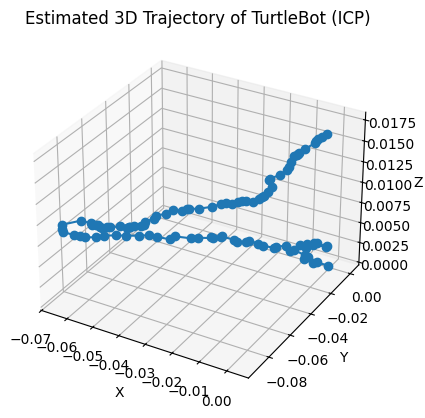

In [ ]:
pcd_files = [f"selected_pcds//pointcloud_{i:04d}.pcd" for i in range(0, 400, 4)]
trajectory_results = []
T_global = None
global_pcd = o3d.geometry.PointCloud()

for i in range(len(pcd_files) - 1):

    pcd1 = o3d.io.read_point_cloud(os.path.join(pcd_files[i]))
    pcd2 = o3d.io.read_point_cloud(os.path.join(pcd_files[i + 1]))

    pcd1_down = pcd1.voxel_down_sample(voxel_size)
    pcd2_down = pcd2.voxel_down_sample(voxel_size)

    reg_p2p = o3d.pipelines.registration.registration_icp(
        pcd1_down, pcd2_down, best_threshold, best_transformation_matrix,
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )

    if T_global is None:
        T_global = best_transformation_matrix
        trajectory_results.append(list(T_global[:3, 3]))

    T_global = T_global @ reg_p2p.transformation  
    trajectory_results.append(list(T_global[:3, 3]))

    pcd2_down = pcd2.voxel_down_sample(voxel_size)
    pcd2_down.transform(T_global)

    global_pcd += pcd2_down

trajectory_df = pd.DataFrame(trajectory_results, columns=['x', 'y', 'z'])
trajectory_df.to_csv("2022482_icp.csv", index=False)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory_df['x'], trajectory_df['y'], trajectory_df['z'], marker='o', linestyle='-')
ax.set_title('Estimated 3D Trajectory of TurtleBot (ICP)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

o3d.visualization.draw_geometries([global_pcd])